## Bayesian Correlations

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


import tensorflow as tf
import keras as kr

import datetime
import matplotlib.dates as mdates

import seaborn as sns
sns.set(palette="Set2")

minute_stock_data_OCT2010 = np.genfromtxt('mquote201010.csv', delimiter=',',names=True,dtype=None)


Using Theano backend.


## Return to Index 
- [Index](http://141.142.208.248:8000/notebooks/BW-Project/Index%20Page.ipynb)

In [11]:
import pymc3 as pm

In [12]:
r_top = find_top_ten('A',stock_market_symbols)

In [13]:
stock_A_data = pull_all_data_in_month(minute_stock_data_OCT2010,'A')

In [14]:
print(len(stock_A_data))

8211


#### Stock A Shares Stongerst Correlation with Stock CVH

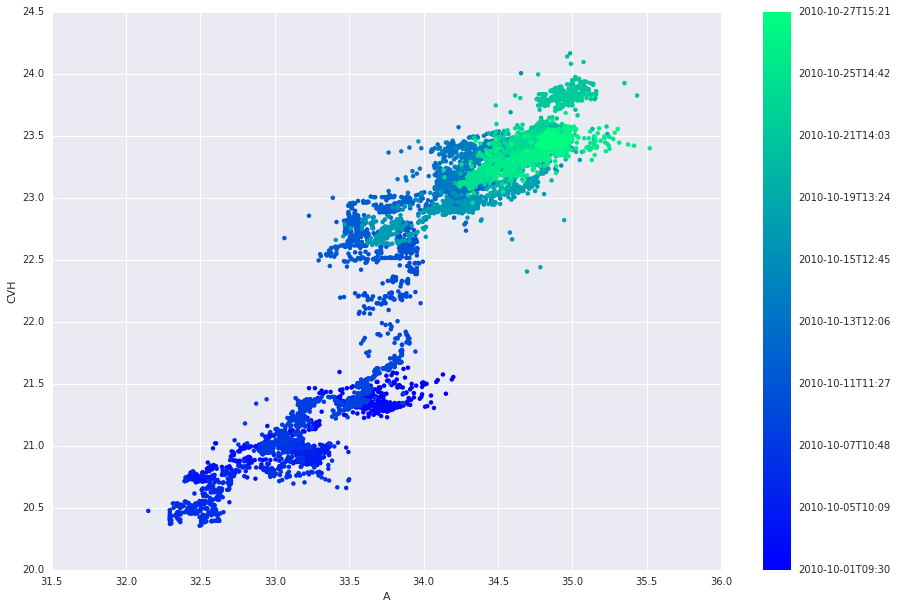

In [15]:
bayesian_correlation('A','CVH')


In [16]:
with pm.Model() as model_reg:
    pm.glm.glm('CVH ~ A', stock_dataframe)
    trace_reg = pm.sample(2000)

100%|██████████| 2000/2000 [01:40<00:00, 19.96it/s]


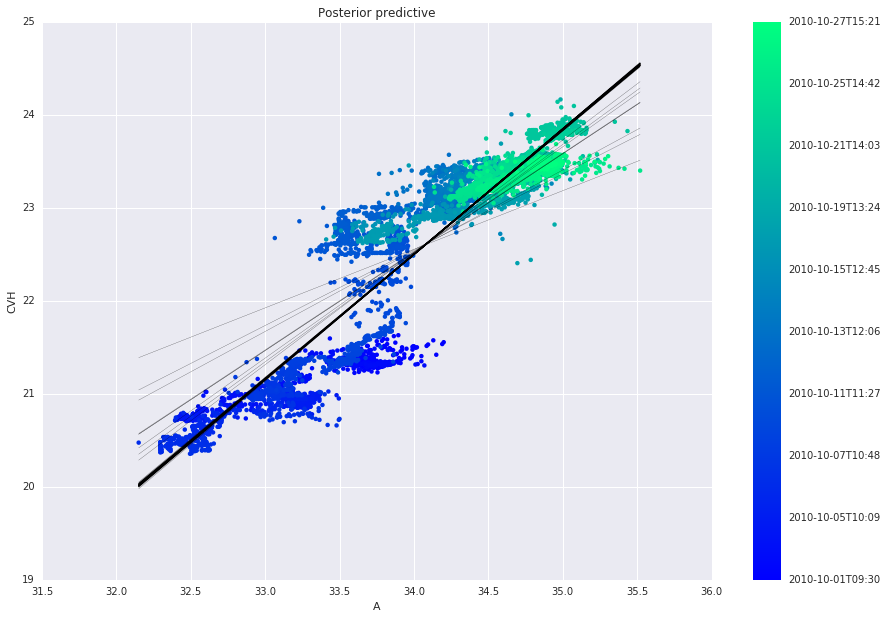

In [17]:
sc=bayesian_correlation('A','CVH')
pm.glm.plot_posterior_predictive(trace_reg[100:], samples=100,
                              label='posterior predictive regression lines',
                              lm=lambda x, sample: sample['Intercept'] + sample['A'] * x,
                              eval=np.linspace(stock_dataframe.A.min(), stock_dataframe.A.max(), 100))


In [18]:
model_randomwalk = pm.Model()
with model_randomwalk:
    # std of random walk, best sampled in log space.
    sigma_alpha = pm.Exponential('sigma_alpha', 1./.02, testval = .1)
    sigma_beta = pm.Exponential('sigma_beta', 1./.02, testval = .1)

In [19]:
import theano.tensor as T

In [20]:
subsample_alpha = 51 #has to divide evenly into data set
subsample_beta = 51
with model_randomwalk:
    alpha = pm.GaussianRandomWalk('alpha', sigma_alpha**-2,
                                  shape=len(stock_dataframe) // subsample_alpha)
    beta = pm.GaussianRandomWalk('beta', sigma_beta**-2,
                                 shape=len(stock_dataframe) // subsample_beta)

    # Make coefficients have the same length as prices
    alpha_r = T.repeat(alpha, subsample_alpha)
    beta_r = T.repeat(beta, subsample_beta)


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '26890' (I am process '27934')


In [21]:
print(alpha_r,beta_r)

Reshape{1}.0 Reshape{1}.0


In [22]:
with model_randomwalk:
    # Define regression
    regression = alpha_r + beta_r * stock_dataframe.A.values

    # Assume prices are Normally distributed, the mean comes from the regression.
    sd_A_CVH = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('y',
                           mu=regression,
                           sd=sd_A_CVH,
                           observed=stock_dataframe.CVH.values)


In [23]:
from scipy import optimize
with model_randomwalk:
    # First optimize random walk
    start = pm.find_MAP(vars=[alpha, beta], fmin=optimize.fmin_l_bfgs_b)

    # Sample
    step = pm.NUTS(scaling=start)
    trace_rw = pm.sample(2000, step, start=start)

    #Choose better starting values, maximum likliehood
    #Do course fit and try getting every 10th fit
    

100%|██████████| 2000/2000 [3:40:28<00:00,  6.55s/it]


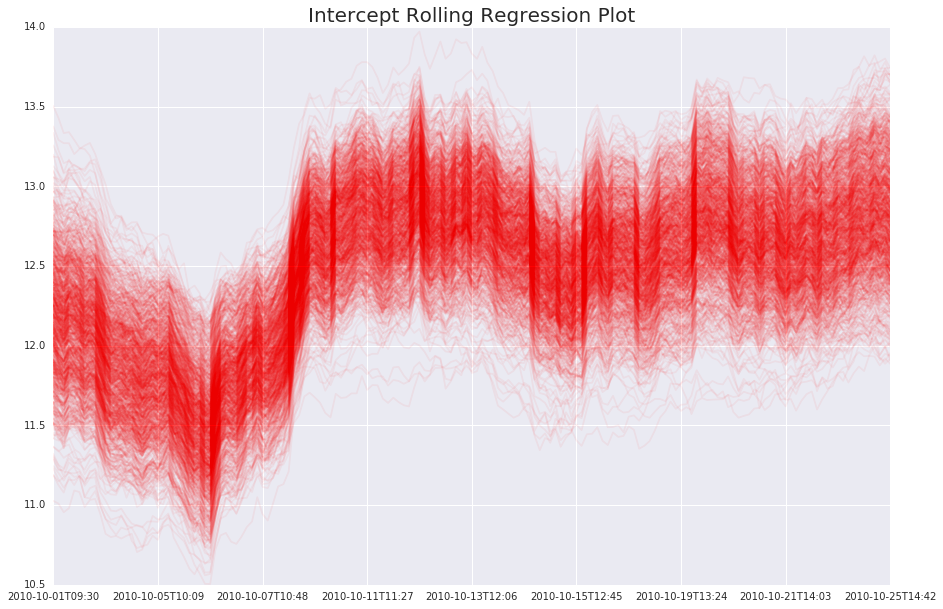

In [24]:
fig_A_CVH_intercept, ax_A_CVH_intercept = plt.subplots(figsize=(15,10))
ax_A_CVH_intercept.plot(trace_rw[-1000:][alpha].T, 'r', alpha=.05);
ax_A_CVH_intercept.set_xticklabels([time for time in time_stamps[::len(time_stamps)//10]]);
plt.title('Intercept Rolling Regression Plot',fontsize=20)

beta


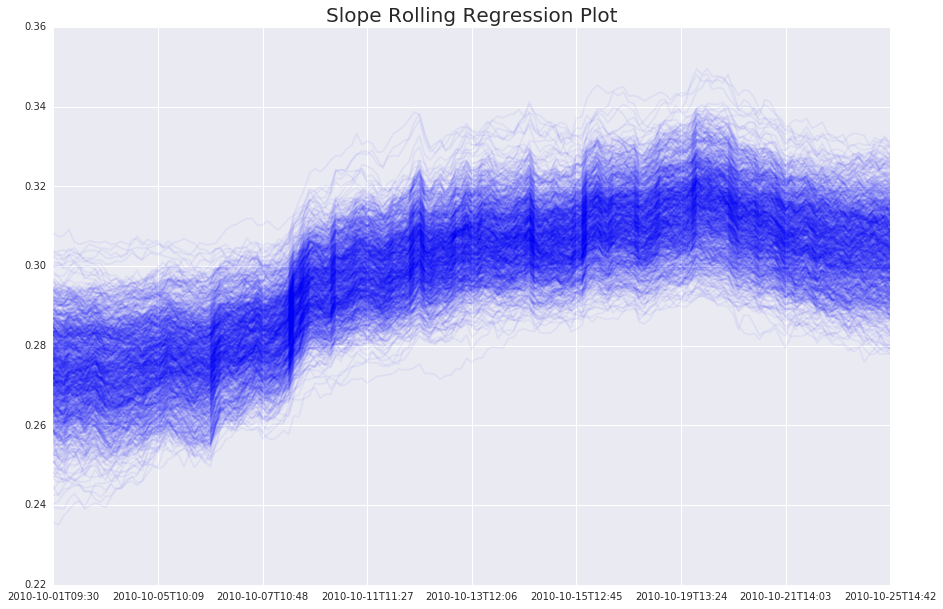

In [25]:
fig_A_CVH_Slope, ax_A_CVH_Slope = plt.subplots(figsize=(15,10))
ax_A_CVH_Slope.plot(trace_rw[-1000:][beta].T, 'b', alpha=.05);
print(beta)
ax_A_CVH_Slope.set_xticklabels([time for time in time_stamps[::len(time_stamps)//10]]);
plt.title('Slope Rolling Regression Plot',fontsize=20)

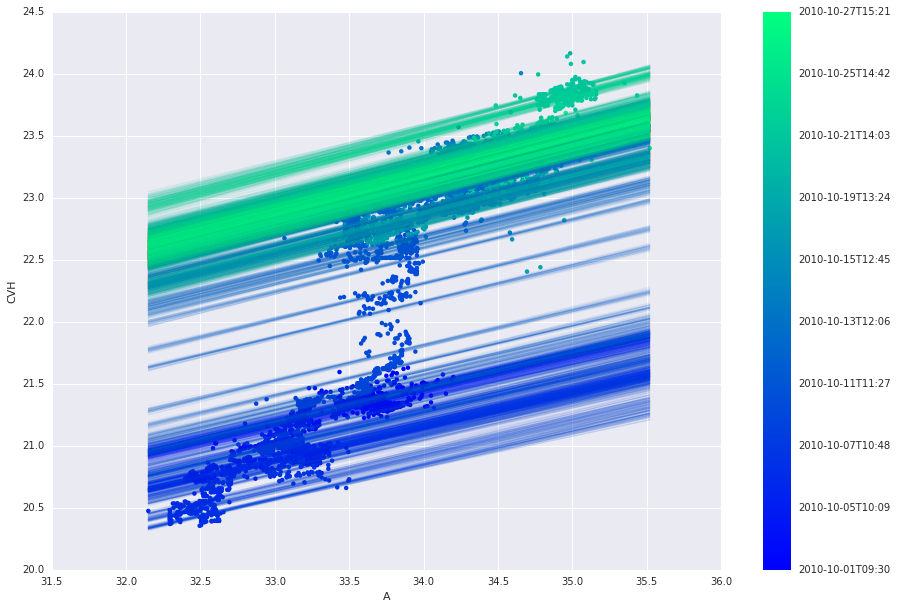

In [26]:
sc=bayesian_correlation('A','CVH')
colors_sc = np.linspace(0.1, 1, len(trace_rw[-500::10]['alpha'].T))
mymap_sc = plt.get_cmap("winter")
xi_A_CVH = np.linspace(stock_dataframe.A.min(), stock_dataframe.A.max(), 51)
for i, (alpha, beta) in enumerate(zip(trace_rw[-500::10]['alpha'].T, trace_rw[-500::10]['beta'].T)):
    for a, b in zip(alpha, beta):
        plt.plot(xi_A_CVH, a + b*xi_A_CVH, alpha=.05, lw=1, c=mymap_sc(colors_sc[i]))

In [2]:
def pull_stock_from_symbol(stock_data,symbol):
    #definition to pull specific index of stock data given symbol
    for i in range(minute_stock_data_OCT2010_length):
        if(minute_stock_data_OCT2010[i][0].decode("utf-8")==symbol):
            return i
        else:
            i+=stock_steps
    return False

In [3]:
def pull_all_data_in_month(stock_data,symbol):
    start_index = pull_stock_from_symbol(stock_data,symbol)
        #Get the correct start index for stock
    symbol_month_data = np.zeros(shape=(8211,),dtype=np.float)
        #Create an empty array of correct size
        #Fill it in with a double array
    index = 0 
    for x in range (start_index,start_index+21):
        for y in range(3,394):
            symbol_month_data[index]=minute_stock_data_OCT2010[x][y]
            #print(symbol_month_data[index])
            index+=1

    #print(index)  
    return symbol_month_data

In [4]:
def find_top_ten(symbol1,stocks):
    stock1 = pull_all_data_in_month(minute_stock_data_OCT2010,symbol1) #stock we are doing comparisons against
    correlations = [(stock,np.corrcoef(stock1,pull_all_data_in_month(minute_stock_data_OCT2010,stock))[1,0]) for stock in stocks if stock!=symbol1]
    return sorted(correlations, key=lambda tup: abs(tup[1]),reverse=True)[:10]

In [5]:
minute_stock_data_OCT2010_length = len(minute_stock_data_OCT2010) 
    #number of elements within the array
stock_steps = 21 
    #number of indices between separate stocks
start_day_index = 3 
    #where first minute starts
end_day_index = 393 
    #where last minute ends

time_stamps_temp = np.arange('2010-10-01T09:30', '2010-10-29T16:01', dtype='datetime64[m]')
count = 0
indexes = np.zeros(shape=(11520,),dtype=np.int)
for i in range(len(time_stamps_temp)):
    current_date = (str(time_stamps_temp[i]))[0:10]
    if(np.is_busday(current_date)==False):
         indexes[count]=int(i)
         count+=1
    else:
        pass
time_stamps = np.delete(time_stamps_temp,indexes)


num_over = 0
indexes_num2 = np.zeros(shape=(20980,),dtype=int)
for x in range(len(time_stamps)):        
    if('16:01' in str(time_stamps[x])):
        for y in range(1049):
            indexes_num2[num_over]=(x+y)
            num_over+=1

time_stamps = np.delete(time_stamps,indexes_num2)

time_stamps_real = np.zeros(shape=(8211,),dtype='datetime64[m]')
#Method instead just append np arrange on to the end of the thingies.

num_min_in_buisnness_month = len(time_stamps)
    #Number of minute level data points per the october month.

In [6]:
def print_stock_symbols():
    i = 0
    stock_market_symbols = []
    for x in range(len(minute_stock_data_OCT2010)):
        if(x%21==0):
            #print(minute_stock_data_OCT2010[x][0].decode("utf-8"))
            #print(minute_stock_data_OCT2010[x][0].decode("utf-8"))
            stock_market_symbols.append(minute_stock_data_OCT2010[x][0].decode("utf-8"))
            i+=1
            #print(i)
    return stock_market_symbols

In [7]:
stock_market_symbols=print_stock_symbols()


In [8]:
def bayesian_correlation(symbol1,symbol2):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, xlabel=symbol1, ylabel=symbol2)
    colors = np.linspace(0.1, 1, len(stock_A_data))
    mymap = plt.get_cmap("winter")
    sc = ax.scatter(pull_all_data_in_month(minute_stock_data_OCT2010,symbol1), pull_all_data_in_month(minute_stock_data_OCT2010,symbol2), c=colors, cmap=mymap, lw=0)
    cb = plt.colorbar(sc)
    cb.ax.set_yticklabels([time for time in time_stamps[::len(time_stamps)//10]]);
    return sc

In [9]:
def create_dataframe(stock_data):
    stock_dictionary ={symbol: pull_all_data_in_month(minute_stock_data_OCT2010,symbol) for symbol in stock_data}
    stock_dataframe = pd.DataFrame(stock_dictionary,index=time_stamps)
    return stock_dataframe

In [10]:
stock_dataframe=create_dataframe(stock_market_symbols)